# Import

In [82]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/skolanko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/skolanko/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

In [83]:
# Load the data
data = pd.read_csv('realdonaldtrump.csv')
dataOriginal = data.copy()

# remove records containing URL
def remove_url(content):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',content)

# remove twiiter links to pictures: like pic.twitter.com
def remove_pic(content):
				pic = re.compile(r'pic.twitter.com/\S+')
				return pic.sub(r'',content)

# remove mentions like @username: and like @ username:
def remove_ment(content):
    mention1 = re.compile(r'@ \w+')
    mention2 = re.compile(r'@\w+')
    content = mention1.sub(r'',content)
    return mention2.sub(r'',content)

# remove punctuations
def remove_punct(content):
    table = str.maketrans('', '', string.punctuation)
    return content.translate(table)

# remove html tags
def remove_html(content):
    html=re.compile(r'<.*?>')
    return html.sub(r'',content)

# remove emojis
def remove_emoji(content):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', content)

#	decontraction
def decontraction(content):
    content = re.sub(r"won\'t", " will not", content)
    content = re.sub(r"won\'t've", " will not have", content)
    content = re.sub(r"can\'t", " can not", content)
    content = re.sub(r"don\'t", " do not", content)

    content = re.sub(r"can\'t've", " can not have", content)
    content = re.sub(r"ma\'am", " madam", content)
    content = re.sub(r"let\'s", " let us", content)
    content = re.sub(r"ain\'t", " am not", content)
    content = re.sub(r"shan\'t", " shall not", content)
    content = re.sub(r"sha\n't", " shall not", content)
    content = re.sub(r"o\'clock", " of the clock", content)
    content = re.sub(r"y\'all", " you all", content)

    content = re.sub(r"n\'t", " not", content)
    content = re.sub(r"n\'t've", " not have", content)
    content = re.sub(r"\'re", " are", content)
    content = re.sub(r"\'s", " is", content)
    content = re.sub(r"\'d", " would", content)
    content = re.sub(r"\'d've", " would have", content)
    content = re.sub(r"\'ll", " will", content)
    content = re.sub(r"\'ll've", " will have", content)
    content = re.sub(r"\'t", " not", content)
    content = re.sub(r"\'ve", " have", content)
    content = re.sub(r"\'m", " am", content)
    content = re.sub(r"\'re", " are", content)
    return content

def seperate_alphanumeric(content):
    words = content
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

# find repeated characters
def cont_rep_char(content):
    tchr = content.group(0)

    if len(tchr) > 1:
        return tchr[0:2]

#	remove repeated characters
def unique_char(rep, content):
    substitute = re.sub(r'(\w)\1+', rep, content)
    return substitute

# to lower case
data['content'] = data['content'].apply(lambda x : x.lower())

# remove all the unwanted words	
data['content'] = data['content'].apply(lambda x : remove_pic(x))
data['content'] = data['content'].apply(lambda x : remove_url(x))
data['content'] = data['content'].apply(lambda x : remove_ment(x))
data['content'] = data['content'].apply(lambda x : remove_punct(x))
data['content'] = data['content'].apply(lambda x : remove_emoji(x))


# do the rest	of the cleaning
data['content'] = data['content'].apply(lambda x : decontraction(x))
data['content'] = data['content'].apply(lambda x : seperate_alphanumeric(x))
data['content'] = data['content'].apply(lambda x : unique_char(cont_rep_char,x))

# drop duplicates
data = data.drop_duplicates(subset=['content'])

# drop records with empty content
data = data.dropna(subset=['content'])

# remove not needed columns
data = data.drop(['link','mentions','hashtags'], axis=1)

# get stopwords to remove
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')

def preprocess(text, stem=False):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

data['content'] = data['content'].apply(lambda x : preprocess(x))

# NLP model

In [84]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(sentence):
    result = sia.polarity_scores(sentence)
    return result['compound'], result['neg'], result['neu'], result['pos']

data['content'] = data['content'].astype(str)

dataSentiment = data.copy()

dataSentiment['compound'], dataSentiment['negative'], dataSentiment['neutral'], dataSentiment['positive'] = zip(*data['content'].apply(analyze_sentiment))

def categorize_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

dataSentiment['sentiment'] = dataSentiment['compound'].apply(categorize_sentiment)

dataSentiment = dataSentiment.drop(columns=['retweets', 'favorites', 'date'])
pd.set_option('display.max_colwidth', None)
dataSentiment.sample(5)

,id,content,compound,negative,neutral,positive,sentiment
1719,186867133651746816,loses wisconsin tomorrow still doesnt get realize point cont,-0.3182,0.223,0.777,0.000,negative
6532,302445095553232897,remember dont promote one else likewise believe yourselfor one else either,-0.2924,0.179,0.821,0.000,negative
22487,595806810738728960,,0.0000,0.000,0.000,0.000,neutral
30195,776773380414537728,going brand new trump international hotel dc major statement,0.0000,0.000,1.000,0.000,neutral
16192,483364885082808320,love sign well done,0.7430,0.000,0.241,0.759,positive


# Data presentation

In [94]:
pd.set_option('display.max_colwidth', None)
dataSentiment.sample(5)

,id,content,compound,negative,neutral,positive,sentiment
2512,223840109542387713,wants see 10 yrs tax returnstell okbut want see college applications first,0.0772,0.0,0.894,0.106,positive
1155,159416243881914368,approve keystone pipeline canada looking sell oil china cont,0.0000,0.0,1.000,0.000,neutral
38169,1146625696531456000,today stock market highest history great country 104 th time since election 2016 reached new high congratulations usa,0.8555,0.0,0.615,0.385,positive
3833,258589709608034304,really enjoyed discussing yesterday long time yankee fan,0.7089,0.0,0.504,0.496,positive
1037,151662732402376704,tops 500 best hotels world congrats,0.8979,0.0,0.216,0.784,positive


Number of positive tweets: 23595


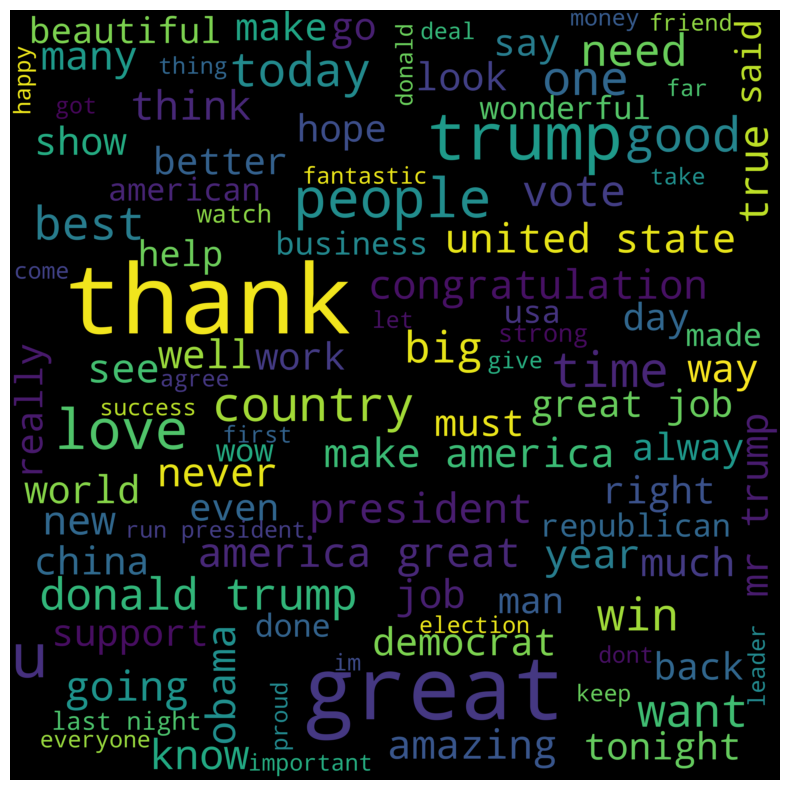

Number of negative tweets: 10309


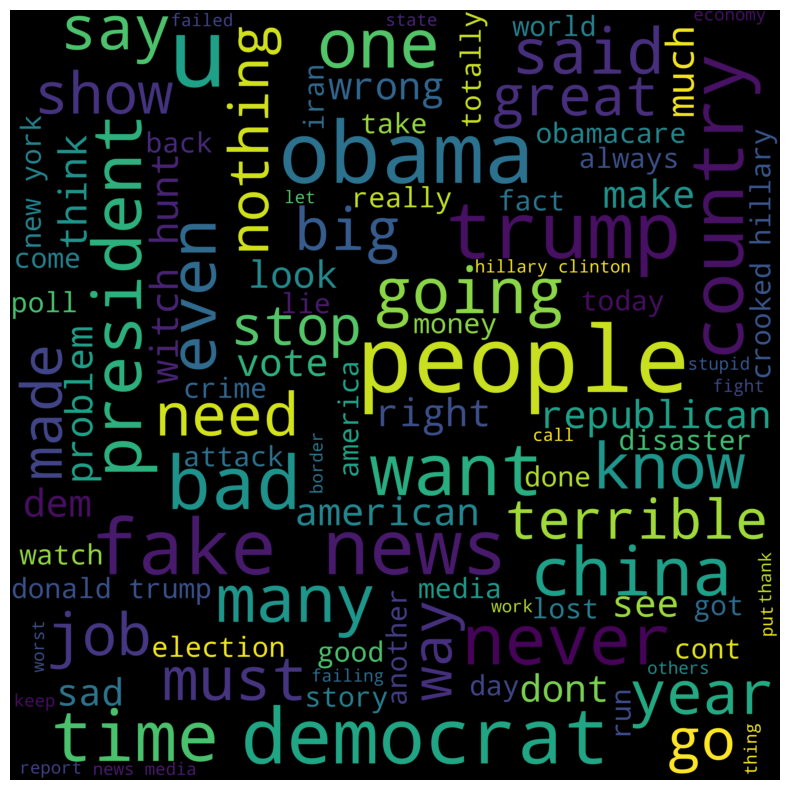

Number of neutral tweets: 6695


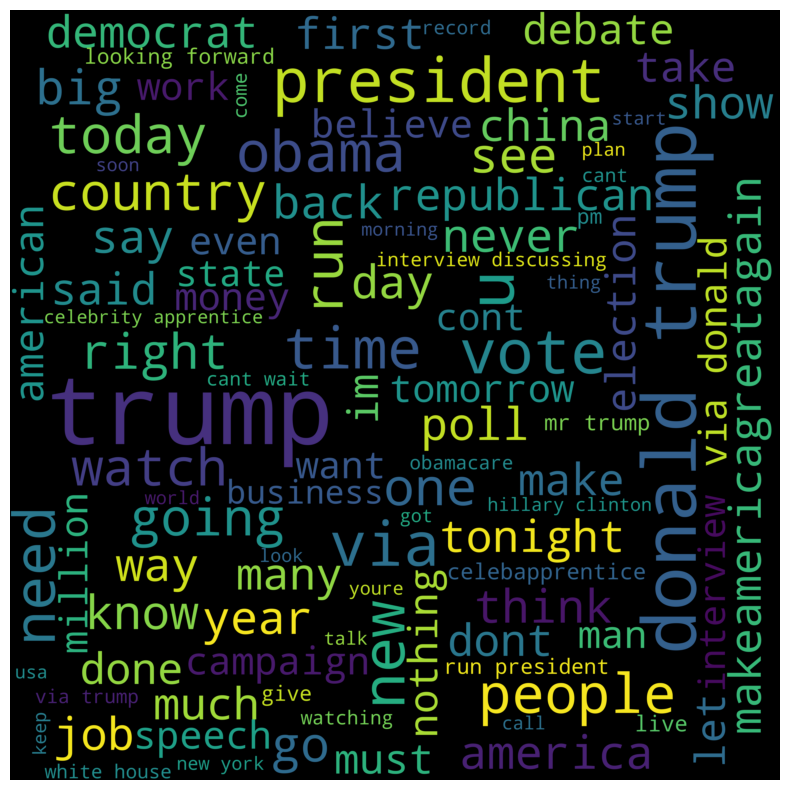

In [89]:
for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_data = dataSentiment[dataSentiment['sentiment'] == sentiment]
    print(f"Number of {sentiment} tweets: {sentiment_data.shape[0]}")
    word_cloud_text = ' '.join(sentiment_data['content'] )
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=800
    ).generate(word_cloud_text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# SHAP analysis

In [87]:
# Przygotowanie danych do modelu
X = dataSentiment[[ 'negative', 'neutral', 'positive', 'compound']]
y = dataSentiment['sentiment']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trening modelu Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred = model.predict(X_test)

# Raport klasyfikacji
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      2096
     neutral       1.00      1.00      1.00      1362
    positive       1.00      1.00      1.00      4662

    accuracy                           1.00      8120
   macro avg       1.00      1.00      1.00      8120
weighted avg       1.00      1.00      1.00      8120



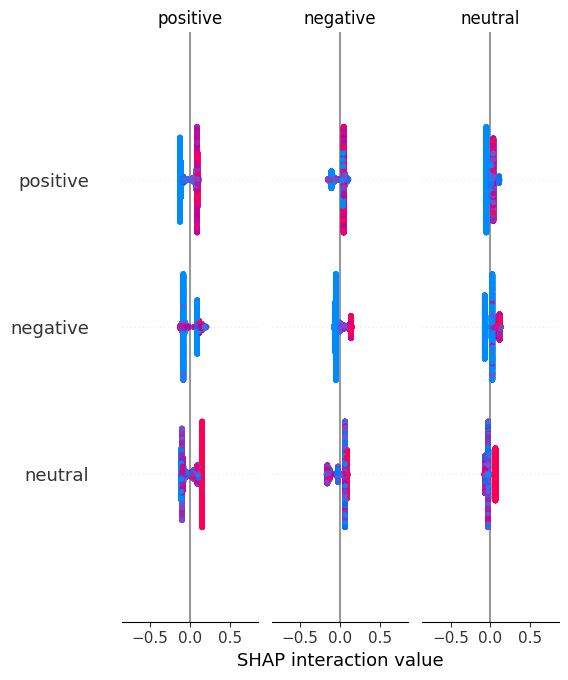

   number          id  \
0       1  1698308935   
1       2  1701461182   
2       3  1737479987   
3       4  1741160716   
4       5  1773561338   

                                                                                                  content  \
0                   sure tune watch donald trump late night david letterman presents top ten list tonight   
1  donald trump appearing view tomorrow morning discuss celebrity apprentice new book think like champion   
2                               donald trump reads top ten financial tips late show david letterman funny   
3                                     new blog post celebrity apprentice finale lessons learned along way   
4                                        persona never wallflower rather build walls cling donald j trump   

                  date  retweets  favorites  
0  2009-05-04 13:54:25       510        917  
1  2009-05-04 20:00:10        34        267  
2  2009-05-08 08:38:08        13         19  
3  2009-05

In [88]:
# Analiza SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Wizualizacja wartości SHAP dla predykcji
shap.summary_plot(shap_values, X_test)

# Zapisanie wyników do nowego pliku CSV
data['number'] = [i+1 for i, _ in enumerate(data.iterrows())]
df = data[['number'] + list(data.columns[:-1])]
df.to_csv('tweets_sentiment_with_model.csv', index=False)
print(df.head())